<a href="https://colab.research.google.com/github/deepu718/tensorflow_practice/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning in tensorflow part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of trasnfer learning: fine-tuning

## Creating helper functions

In previous notebooks we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, its a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).


In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-12 17:21:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-12 17:21:10 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how can we use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-12 17:21:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.6MB/s    in 7.3s    

2023-08-12 17:21:22 (22.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our datasets
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

 ## Model 0: Building a transfer learning feature extraction model using the keras Functional API

 The sequential API is straight-forward, it runs our layers in sequential oreder.

 But the funtctional API gives us more flexibility with our models

In [10]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. if using ResNet50v2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after GlobalAveragePooling2D: {x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs of the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        steps_per_epoch=len(train_data_10_percent),
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning",
                                                               "10_percent_model_0")])

16705208/16705208 [==============================] - 1s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_model_0/20230812-172132
Epoch 1/5
24/24 [==============================] - 22s 288ms/step - loss: 1.8894 - accuracy: 0.4040 - val_loss: 1.3526 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - 5s 178ms/step - loss: 1.1053 - accuracy: 0.7667 - val_loss: 0.9194 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 7s 288ms/step - loss: 0.7991 - accuracy: 0.8227 - val_loss: 0.7310 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 5s 179ms/step - loss: 0.6523 - accuracy: 0.8520 - val_loss: 0.6542 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 5s 168ms/step - loss: 0.5513 - accuracy: 0.8720 - val_loss: 0.5866 - val_accuracy: 0.8421


In [11]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5630 - accuracy: 0.8596


[0.5629827976226807, 0.8596000075340271]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
# How about we get a summary of the base model
base_model.summary()

In [14]:
# How about the summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


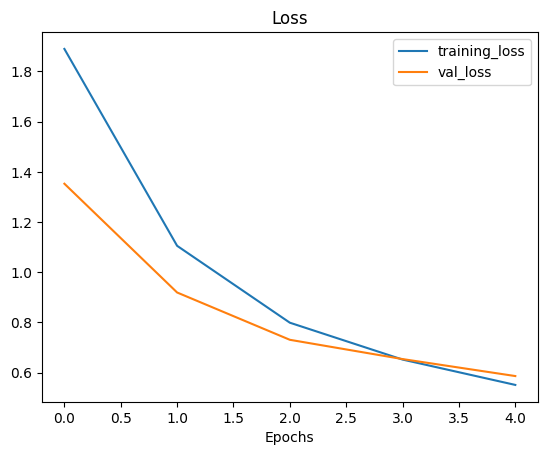

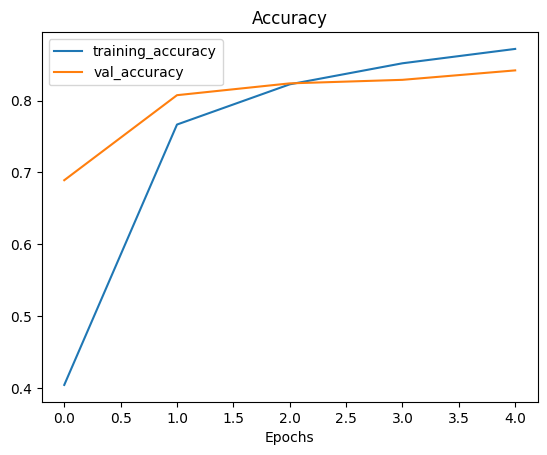

In [15]:
# Check out our models training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the global average pooling 2D layer...

We have a tensor after our model goes through `base model` of shape (None, 7, 7, 1280).

But when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [16]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass the random tensor through the GlobalAveragepooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D globa averaged pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensor
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D globa averaged pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePooled2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data.. how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data augmentation

2. `model_2` - use feature extraction trasnfer learning with 10% of the training with data augmentation

3. `model_3` - ude fine-tuning transfer learning on 10% of the training data with data augmentation

4.  `model_4` - use fine tuning tranfer learning on 100% of the training data with augmentation.

> 🔑 Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## getting and preprocessing data for `model_1`

In [18]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-08-12 17:39:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 172.253.118.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  17.6MB/s    in 8.9s    

2023-08-12 17:39:51 (14.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [20]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [22]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

The benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like resnet50v2
], name= "data_augmentation")

### Visualize our data augmentation layer

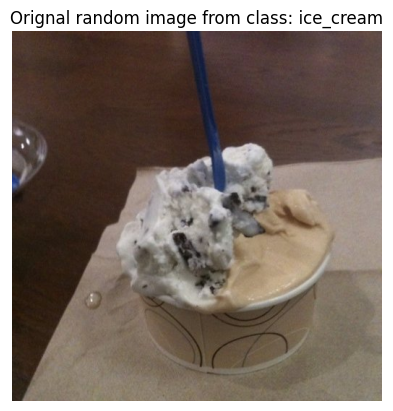

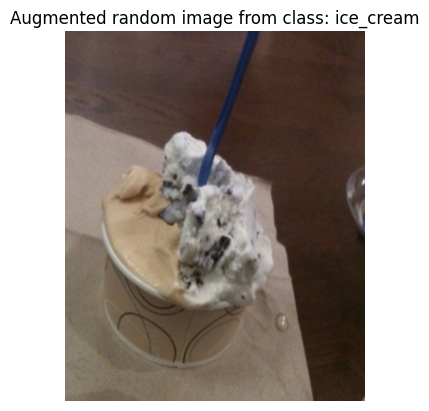

In [38]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img  = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Orignal random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0),training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [40]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a densse layer on as outputs
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs =5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=0.25*len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230812-183736
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.4610 - accuracy: 0.0429 - val_loss: 2.3091 - val_accuracy: 0.0859
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1947 - accuracy: 0.1714 - val_loss: 2.1828 - val_accuracy: 0.2078
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.9441 - accuracy: 0.3857 - val_loss: 2.0639 - val_accuracy: 0.3031
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.7642 - accuracy: 0.5143 - val_loss: 1.9448 - val_accuracy: 0.3797
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6383 - accuracy: 0.6286 - val_loss: 1.8309 - val_accuracy: 0.4563


In [41]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [42]:
# Evaluate on the full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 84ms/step - loss: 1.8662 - accuracy: 0.4232


[1.8661562204360962, 0.42320001125335693]

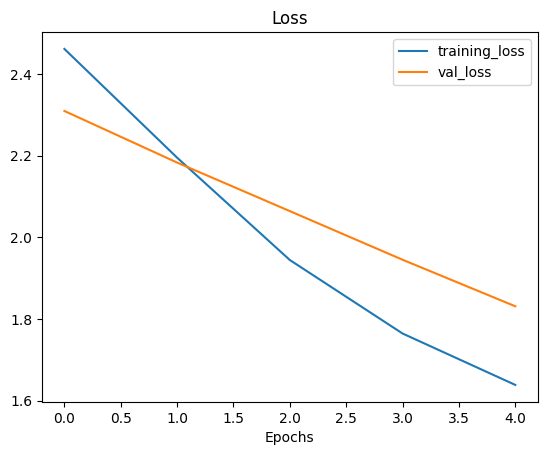

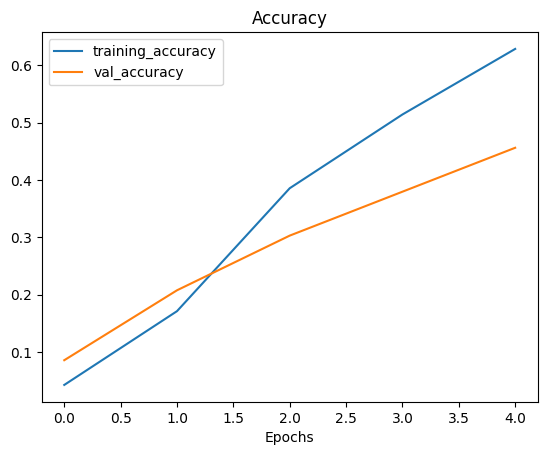

In [43]:
# How do the model with 1% of the data and data aug loss curves look like
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data

In [44]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [45]:
# set data inputs
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [47]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
],name="data_augmentation")

# Setup input to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layer in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training =False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

model_2 = tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



### Creating a ModelCheckPoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can came and start where we left off

In [48]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [50]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5

history_2 = model_2.fit(train_data_10_percent,
                        epochs = initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "10_percent_data_aug"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230812-194756
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9646 - accuracy: 0.3760
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 822ms/step - loss: 1.9646 - accuracy: 0.3760 - val_loss: 1.4457 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3135 - accuracy: 0.6933
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 606ms/step - loss: 1.3135 - accuracy: 0.6933 - val_loss: 1.0355 - val_accuracy: 0.7533
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0011 - accuracy: 0.7613
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 638ms/step - loss: 1.0011 - accuracy: 0.7613 - val_loss: 0.7902 - val_accuracy: 0.8092
E

In [51]:
# What were model 0 results
model_0.evaluate(test_data)

79/79 [==============================] - 11s 109ms/step - loss: 0.5630 - accuracy: 0.8596


[0.5629828572273254, 0.8596000075340271]

In [53]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 10s 112ms/step - loss: 0.6213 - accuracy: 0.8444


[0.621324360370636, 0.8443999886512756]

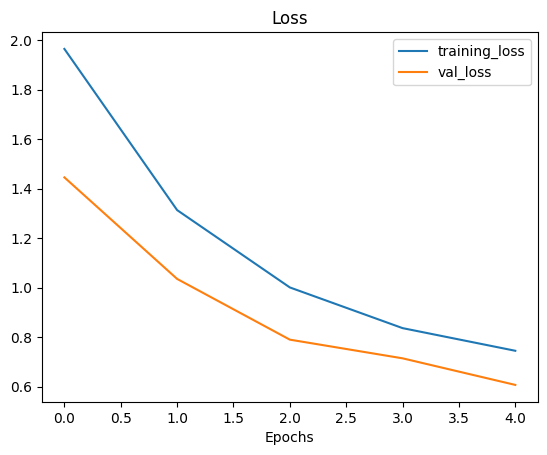

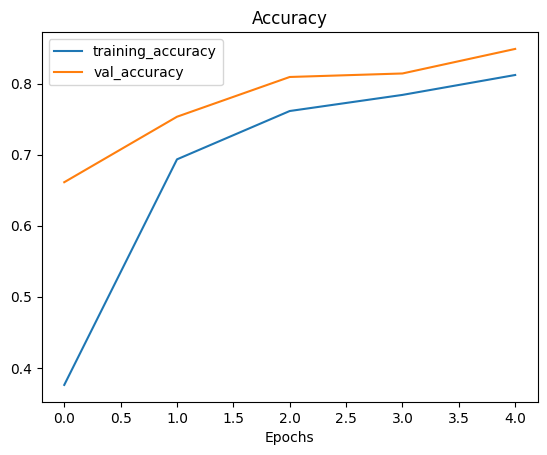

In [54]:
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [56]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [57]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 10s 99ms/step - loss: 0.6213 - accuracy: 0.8444


In [58]:
# Check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(loaded_weights_model_results),np.array(results_10_percent_data_aug))

array([ True,  True])